In [1]:
%matplotlib inline

import os

import ipywidgets as widgets
from ipywidgets import interactive, fixed, HBox, VBox, interact_manual, Label
from ipyfilechooser import FileChooser
from IPython.display import HTML, Markdown, display, clear_output

import pipython

import manipylator
import manipylator.utils as utils 
import manipylator.gui as gui
from manipylator.utils import printmd 
from manipylator.analysis import tune_detect_bead
from manipylator.controller import Controller, get_stage_prop

print("Running PIPython {}".format(pipython.__version__))

cwd = os.getcwd()

#if need be find DLL path with pidevice.dllpath



                        _             _       _             
  _ __ ___   __ _ _ __ (_)_ __  _   _| | __ _| |_ ___  _ __ 
 | '_ ` _ \ / _` | '_ \| | '_ \| | | | |/ _` | __/ _ \| '__|
 | | | | | | (_| | | | | | |_) | |_| | | (_| | || (_) | |   
 |_| |_| |_|\__,_|_| |_|_| .__/ \__, |_|\__,_|\__\___/|_|   
                         |_|    |___/                       
 
 A Python-driven manipulator controller 

 Developed and maintained by Arthur Michaut: arthur.michaut@gmail.com 




/opt/miniconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Running PIPython 2.8.0.3


In [2]:
printmd("**Choose saving directory**")
fc = FileChooser(cwd)
fc.use_dir_icons = True
display(fc)

printmd("**Select the stages (1 or several) you want to connect**")
stages_wid = widgets.SelectMultiple(options=['piezo', 'stepper'],value=['piezo'])
display(stages_wid)

printmd("Are they virtual stages (useful for offline debugging)?")
virtual_wid = widgets.ToggleButton(value=False, description='Virtual stage')
display(virtual_wid)

**Choose saving directory**

FileChooser(path='/Users/amichaut/Documents/Work/codes/manipulator', filename='', title='', show_hidden=False,…

**Select the stages (1 or several) you want to connect**

SelectMultiple(index=(0,), options=('piezo', 'stepper'), value=('piezo',))

Are they virtual stages (useful for offline debugging)?

ToggleButton(value=False, description='Virtual stage')

## Connect stage

In [4]:
controller_dict = {}
for i in range(len(stages_wid.value)):
    print('connecting to {} stage...'.format(stages_wid.value[i]))
    stage_properties = get_stage_prop(kind=stages_wid.value[i])
    controller = Controller(stage_properties)
    controller.connect(virtual=virtual_wid.value)
    controller_dict[stages_wid.value[i]] = controller
    print('\n')
    
if fc.selected_path is not None:
    saving_dir = fc.selected_path
else: 
    saving_dir = cwd
print("Saving directory is: {}".format(saving_dir))

connecting to piezo stage...
Running a virtual stage
Stage raw position: 0 um. 
Stage transformed position: 500 um.


Saving directory is: /Users/amichaut/Documents/Work/codes/manipulator


## Basic dashboard
Display and control the stage(s) position. The position is dispayed as the 'raw position' (i.e. the position in the stage referential), and the 'transformed position' (i.e. the position in the image referential). Only the transformed position will be used to measure deflections. 

In [5]:
stage_list = list(controller_dict.keys())

gui.make_basic_dashboard(controller_dict,virtual_wid.value)

## Choose active stage for assays

In [6]:
printmd("**Choose active stage for assays**")

if len(stage_list) == 0:
    raise Exception('Error: at least one stage must be connected')
elif len(stage_list) == 1:
    controller = controller_dict[stage_list[0]]
    print("the {} stage is active for running assays".format(stage_list[0]))
else: 
    stage_select_wid = widgets.Dropdown(options=stage_list,value='piezo',description='Active stage:',)
    display(stage_select_wid)

**Choose active stage for assays**

the piezo stage is active for running assays


In [7]:
if len(stage_list) > 1:
    controller = controller_dict[stage_select_wid.value]
    print("the {} stage is active for running assays".format(stage_select_wid.value))

# Assays

## Chirp

Run an oscillating assay with a variable frequency sweeping a range between two boundaries as described in Geri et al 2018 https://doi.org/10.1103/PhysRevX.8.041042

**WARNING: No outfile name given!**

Positions data will be saved to: /Users/amichaut/Documents/Work/codes/manipulator/20230322_19-19-12.csv

Parameters will be saved to: /Users/amichaut/Documents/Work/codes/manipulator/20230322_19-19-12_param.csv

step interval = 1.0 sec


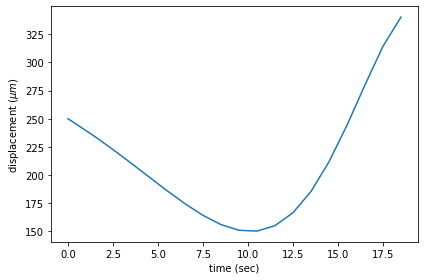

Button(description='Run chirp', style=ButtonStyle())

low angular frequency: period = 62.83 s
high angular frequency: period = 12.57 s


In [8]:
%matplotlib inline

#parameters
parameters = {'x0' : 100,  # half amplitude um
            'center_position' : 250,  # um
            'low_angular_freq' : 0.1,  # rad/sec
            'high_angular_freq' : 0.5,  # rad/sec
            'total_time' : 20,  # sec
            'num_points' : 20,  # number of points
            'out_fn' : None,  # if False: not saving, if None: saving with date and time as filename
            }

gui.run_chirp(controller,parameters,saving_dir)


------
## Linear sweeps

Sweep positions linearly in time between two boundaries. Several successive sweeps can be defined. 

In [17]:
sweep_num = 4  # number of successive sweeps
rate_def = 'time' # definition for sweep rate in total time ('time') or speed ('speed')
steps_def = 'freq'  # definition for number of steps in total number ('total') or frequency ('freq')

sweep_widgets = gui.get_sweep_parameters(controller, sweep_num, rate_def, steps_def)

**WARNING: No outfile name given!**

Positions data will be saved to: /Users/amichaut/Documents/Work/codes/manipulator/20221202_16-31-39.csv

Parameters will be saved to: /Users/amichaut/Documents/Work/codes/manipulator/20221202_16-31-39_param.csv

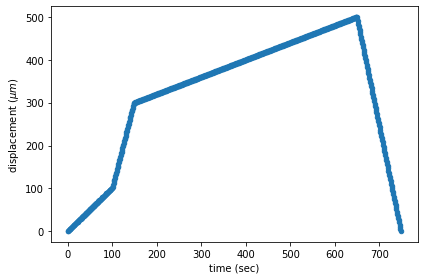

Button(description='Run sweep', style=ButtonStyle())

In [18]:
%matplotlib inline

#parameters
parameters = {'sweep_num': sweep_num,  # number of successive sweeps
              'boundaries': [[sweep_widgets['bound_1_list'][i].value, sweep_widgets['bound_2_list'][i].value] for i in range(sweep_num)],  # list of boundaris in um
              'rate_def': rate_def,  # definition for sweep rate in total time ('time') or speed ('speed')
              'steps_def': steps_def,  # definition for number of steps in total number ('total') or frequency ('freq')
              'time_unit': [sweep_widgets['unit_list'][i].value for i in range(sweep_num)],  # time unit used for sweep rate
              'rate': [sweep_widgets['rate_list'][i].value for i in range(sweep_num)],  # sweep time or sweep speed dependeing on rate_def
              'num_steps': [sweep_widgets['steps_list'][i].value for i in range(sweep_num)],  # number of steps or step frequency depending steps_def
              'print_pos': True,  # print the position of stage
              'correction_time': 0.05,  # time to compensate for code execution (in sec). Typically=0.05
              'out_fn': None,  # if False: not saving, if None: saving with date and time as filename
              }

sweep = gui.run_sweep(controller, parameters, saving_dir, plot='show')

-------
## Force controller
Apply controlled forces through a cantilever-based actuator. 
To do so, the cantilever's tip deflection is measured and controlled in real time though a feedback algorithm. In brief, the cantilever's tip is detected by image analysis, the deflection (compared to the zero-force state) is calculated and fed to a [PID algorithm](https://en.wikipedia.org/wiki/PID_controller) which outputs a corrected position to the stage to maintain the prescribed deflection.

Before applying forces, two initialization steps are necessary: 
- the tip detection parameters must be tuned: two dectection methods are available (pattern recognition, Hough transform)
- the offset between the stage position and the tip position must be measured at in a zero-force state. the deflection is defined as a variation of the offset compared to the zero-force state.

In [7]:
tip_widgets = gui.get_tip_parameters(saving_dir)

**Choose image directory where tip images are saved**

FileChooser(path='/Users/amichaut/Documents/Work/codes/manipulator', filename='', title='', show_hidden=False,…

**Set image lengthscale (um/px)**

FloatText(value=1.0)

**Choose your tip detection method**

The pattern matching methods tries to fit a reference pattern (defined by a region of interest) 
    in an image. The Hough transform detects circles of a given radius in an image (works only of circular tips)

ToggleButtons(description='Method:', options=('pattern matching', 'Hough transform'), tooltips=('Crosscorrelat…

**Update tip pattern at each time step (if not, keep the initial pattern). Only relevant for the pattern mathcing method.**

Checkbox(value=False, description='Update pattern')

**Filter tip files based on their names.**

Text(value='', description='Filter:', placeholder='name must contain')

In [10]:
method = 'pattern' if tip_widgets['method_wid'].value == 'pattern matching' else 'hough_circle'
tip_properties = {'tip_dir' : tip_widgets['fc_image'].selected_path,
                  'tip_method': method,
                  'tip_fn_filter' : tip_widgets['fn_filter_wid'].value, 
                  'tip_lengthscale':tip_widgets['lengthscale_wid'].value,
                  'update_tip_pattern':tip_widgets['update_pattern_wid'].value,  
                }
controller.update_properties(tip_properties=tip_properties)

In [11]:
%matplotlib inline
detection_param_wid = gui.tune_detection_parameters(controller)

**Select the region of interest (ROI) you want to track**

interactive(children=(Text(value='/Users/amichaut/Desktop/to_delete/0014.tif', description='fn'), IntRangeSlid…

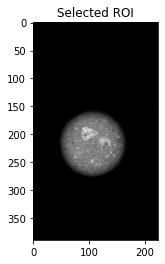

this ROI will be use to track the tip

In [12]:
%matplotlib inline
gui.save_detection_parameters(controller, detection_param_wid)

### Initialize deflection
Deflection is defined as the variation of the offset between the stage and tip positions compared to a reference offset. 
The offset needs to be measured in a **zero-force** state. Make sure that no force is applied to the system when you run the following step.

In [13]:
%matplotlib inline
gui.initialize_deflection(controller)

Initializing deflection with current offset between tip and stage position:  
    - tip position = 429.0 $\mu m$  
    - stage transformed position = 500.0 $\mu m$  
    - offset = tip - stage = -71.0 $\mu m$
    

**Deflection dashboard**

Warning: with the current tip position, only deflections between 0.0 and 500.0 are available.

Positive deflections lead to stage movements towards the left of the image

### Force control assay 
Apply a sequence of prescribed steps of force.

In [12]:
# number of step in sequence
printmd("How many steps do you want to define in the sequence?")
steps_wid = widgets.IntText(value=1,min=1,max=10)
display(steps_wid)

How many steps do you want to define in the sequence?

IntText(value=1)

In [13]:
force_widgets = gui.get_force_sequence(steps_wid.value)

Choose series of constant setpoints and their duration. 
            Optionally, introduce a linear ramp before the step. 
            If ramp duration is 0, there is no ramp. 

**ERROR: /Users/amichaut/Documents/Work/codes/manipulator/test.csv already exists!**

Positions data will be saved to: /Users/amichaut/Documents/Work/codes/manipulator/test_20221122_13-48-16.csv

Parameters will be saved to: /Users/amichaut/Documents/Work/codes/manipulator/test_20221122_13-48-16_param.csv

<IPython.core.display.Javascript object>


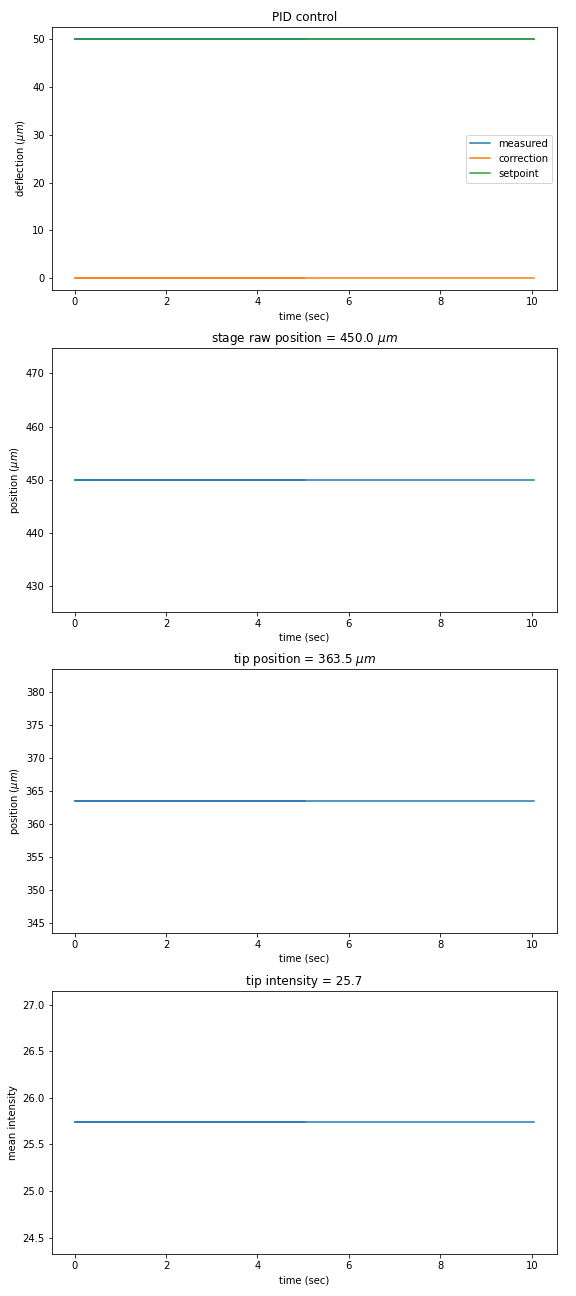

Button(description='Run PID sequence', style=ButtonStyle())

PID control over. Saving data PID sequence data...
Saving data to: /Users/amichaut/Documents/Work/codes/manipulator/test_20221122_13-48-16.csv


In [15]:
%matplotlib notebook

parameters = {'PID_param': [1,0,0], # PID parameters
            'PID_freq': 2, # PID computation frequency
            'plotting_freq': 0.2, # plotting frequency
            'force_widgets': force_widgets, 
            'out_fn': "test.csv",  # if False: not saving, if None: saving with date and time as filename
            }

gui.run_force_sequence(controller,parameters,saving_dir)